In [2]:
from time import time

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.Qsimcirq_CPQAOA import Qsim_CPQAOA
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       qubo_limits, 
                       check_qubo)


In [3]:
N_min, N_max = 6, 18

full_sv_res =      {N: [] for N in range(N_min, N_max + 1)}
truncated_sv_res = {N: [] for N in range(N_min, N_max + 1)}

N_seeds = 6
seed = 0
 # Choosing optimizer for scipy
optimizer_method = 'COBYLA'
for N in tqdm(range(N_min, N_max+1)):
    k = N // 2
    init_strat = np.array([1 if i%2 == 1 else 0 for i in range(N)])
    my_indices = [(i, i+1) for i in range(N-1)]
    n_layers = 4
    alpha = 0.5
    max_iter = 10
    for repetition in range(N_seeds):
         # Defining topology
        my_chain = Chain(N_qubits=N)
        my_chain.set_initialization_strategy(strategy=init_strat)
        # Deciding between grid and 1d chain topology
        my_topology = my_chain
        # Generating random problem instance 
        expected_returns, covariances = portfolio_metrics(n=N, seed=seed)
        # Retrieving C_min, C_max and corresponding states for original portfolio problem
        constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                                    k=k,
                                                                    mu=expected_returns,
                                                                    sigma=covariances,
                                                                    alpha=alpha)
        portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
        portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
        # Generating QUBO corresponding to current problem instance
        Q, offset = get_qubo(mu=expected_returns,
                             sigma=covariances, 
                             alpha=alpha,
                             lmbda=lmbda+1e-8, # Adding small constant purposely
                             k=k)
        QUBO_limits = qubo_limits(Q=Q,offset=offset)
        qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
        qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
        check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
        qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
        
        if not portfolio_subspace_min_state_str == qubo_min_state_str:
            raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}'+f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
        
        if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
            raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
        
        if not qubo_max_cost >= portfolio_subspace_max_cost:
            raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')
         
        full_sv_ansatz = Qsim_CPQAOA(N_qubits=N,
                                    cardinality=k,
                                    layers=n_layers,
                                    QUBO_matrix=Q,
                                    topology=my_topology,
                                    get_full_state_vector=True)
         
        truncated_sv_ansatz = Qsim_CPQAOA(N_qubits=N,
                                        cardinality=k,
                                        layers=n_layers,
                                        QUBO_matrix=Q,
                                        topology=my_topology,
                                        get_full_state_vector=False)
                 
        
        # Generating initial guess for rotation angles
        np.random.seed(seed)
        theta_min, theta_max = -2*np.pi, 2*np.pi
        N_angles = n_layers * len(my_topology.get_NN_indices())
        theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
        
        
        full_sv_start_time = time()
        full_sv_sim = sc.optimize.minimize(fun=full_sv_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        full_sv_stop_time = time()
        if full_sv_sim['nfev'] > 0:
            time_pr_iter = (full_sv_stop_time-full_sv_start_time) / full_sv_sim['nfev']
            full_sv_res[N].append(time_pr_iter)
        
        
        truncated_sv_start_time = time()
        truncated_sv_sim = sc.optimize.minimize(fun=truncated_sv_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        truncated_sv_stop_time = time()
        if truncated_sv_sim['nfev'] > 0:
            time_pr_iter = (truncated_sv_stop_time-truncated_sv_start_time) / truncated_sv_sim['nfev']
            truncated_sv_res[N].append(time_pr_iter)
            
        seed += 1

100%|██████████| 13/13 [06:00<00:00, 27.75s/it]


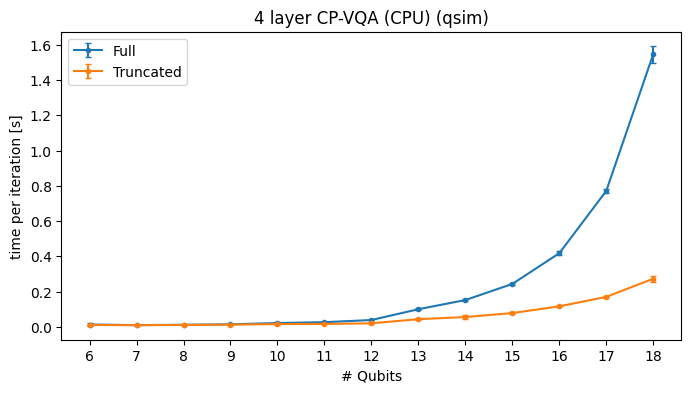

In [5]:
full_sv_avgs = np.array([[np.mean(full_sv_res[key]), np.std(full_sv_res[key])] for key in full_sv_res.keys()])
truncated_sv_avgs = np.array([[np.mean(truncated_sv_res[key]), np.std(truncated_sv_res[key])] for key in truncated_sv_res.keys()])

N_vals = [n for n in range(N_min, N_max+1)]

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.set_title('4 layer CP-VQA (CPU) (qsim)')
ax.errorbar(N_vals, full_sv_avgs[:,0], yerr=full_sv_avgs[:,1], fmt='.-', capsize=2, label='Full', color='tab:blue')
ax.errorbar(N_vals, truncated_sv_avgs[:,0], yerr=truncated_sv_avgs[:,1], fmt='.-', capsize=2, label='Truncated', color='tab:orange')
ax.set_ylabel('time per iteration [s]')
ax.set_xlabel('# Qubits')
ax.set_xticks(N_vals)
ax.legend()
plt.savefig('full_vs_truncated.png',dpi=400)
plt.show()